In [1]:
#Importing packages

import pandas as pd 
import numpy as np


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#Reading raw dataset 

train_dataset=pd.read_csv('../data/raw/train.csv')
test_dataset=pd.read_csv('../data/raw/test.csv')

/var/folders/w6/skyqkqrx1_q7pbxvh4_c7g_00000gn/T/ipykernel_95882/1945781094.py:3: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  train_dataset=pd.read_csv('../data/raw/train.csv')


In [3]:
# Finding the proportion of missing value

train_dataset.isnull().sum()*100/train_dataset.shape[0]


team                    0.000000
conf                    0.000000
GP                      0.000000
Min_per                 0.000000
Ortg                    0.000000
usg                     0.000000
eFG                     0.000000
TS_per                  0.000000
ORB_per                 0.000000
DRB_per                 0.000000
AST_per                 0.000000
TO_per                  0.000000
FTM                     0.000000
FTA                     0.000000
FT_per                  0.000000
twoPM                   0.000000
twoPA                   0.000000
twoP_per                0.000000
TPM                     0.000000
TPA                     0.000000
TP_per                  0.000000
blk_per                 0.000000
stl_per                 0.000000
ftr                     0.000000
yr                      0.520583
ht                      0.174716
num                     8.361413
porpag                  0.000000
adjoe                   0.000000
pfr                     0.000000
year      

In [4]:
# List of data preprocessing that needs to be done 

# Remove team?
# Remove yr
# Remove type as it only contain 1 value
# Remove num ( not important, and will introduce overfitting )
# Remove ftr ( need definition ) USE IN THIS EXPEREMINTAE
# Remove pfr ( need definition ) USE IN THIS EXPEREMINTAE
# Remove year ( based on EDA, and business asumption )
# Remove player ID (will cause overfit)
# Remove ht ( unusable if not processed, will consider in subsequent experiment )
# I dont quite understand how the drafting works, but seems like only players who have values in 'pick' variable deleting this for experiment A while finding out how it works

# Fill in missing value in ht with average ht ( Remove for experiment A )
# Data engineer Rec_Rank 
# Fill in missing value in ast_tov with mean 
# Engineer dunks_ratio by dunksmade/dunksmiss_dunksmade
# Rec_Rank = need to fill out missing value with 0 to capture the state of unranked

# Remove missing obs from rimmade
# Remove missing obs from drtg
# Remove missing obs from mp



In [5]:
# !git add .
# !git commit -m "Initial EDA"
# !git push

In [6]:
# Copying training and testing dataset


train_dataset_copy=train_dataset.copy()
test_dataset_copy=test_dataset.copy()

In [7]:
# Dropping columns that we deem uneccesary from training and test

columns_to_drop=['team','yr','num','year','player_id','ht','pick','type']

train_dataset_copy.drop(columns=columns_to_drop,inplace=True)
test_dataset_copy.drop(columns=columns_to_drop,inplace=True)



In [8]:
# Removing observations with missing values in listed columns

train_dataset_copy.dropna(subset=['rimmade','drtg','mp'],inplace=True)




In [9]:
# Filling in the missing value in ast_tov with the average ast_tov

# Converting the format of height from string to number

avg_height_train=train_dataset_copy['ast_tov'].mean()

train_dataset_copy['ast_tov'].fillna(avg_height_train,inplace=True)


In [10]:
# Replacing dunks_ratio missing value with 0

# Missing value on dunks_ratio are caused by no succesful dunks were made

train_dataset_copy['dunks_ratio'].fillna(0,inplace=True)



In [11]:

# Replacing rim_ratio missing value with 0

# Missing value on rim_ratio are caused by no succesful rimmshot were made


train_dataset_copy['rim_ratio'].fillna(0,inplace=True)






In [12]:

# Replacing mid_ratio missing value with 0

# Missing value on mid_ratio are caused by no midmade_midmiss were made


train_dataset_copy['mid_ratio'].fillna(0,inplace=True)



In [13]:
# Replacing Rec_Rank missing value with 0

# Need to fill out missing value in Rec_Rank with 0 to capture the state of unranked


train_dataset_copy['Rec_Rank'].fillna(0,inplace=True)



In [14]:
# Processing the test dataset seperately as it needs different treatment compared to 


# Filling in the missing value in this list  with the average ast_tov

columns_fill_with_avg=['drtg','adrtg','dporpag','stops',
                       'bpm','obpm','dbpm','gbpm','ogbpm',
                       'dgbpm','ast_tov']
                    
for column in columns_fill_with_avg:
    average=test_dataset_copy[column].mean()
    test_dataset_copy[column].fillna(average,inplace=True)
    


# Filling in the missing value in this list  with 0

columns_fill_with_0=['rimmade','rimmade_rimmiss','midmade',
                     'midmade_midmiss','dunksmade','dunksmiss_dunksmade',
                     'rim_ratio','dunks_ratio','mid_ratio','Rec_Rank']

for column in columns_fill_with_0:
    value_fillup=0
    test_dataset_copy[column].fillna(value_fillup,inplace=True)

                       

In [15]:
train_cleaned=train_dataset_copy
test_cleaned=test_dataset_copy

In [16]:
train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50006 entries, 4589 to 56089
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   conf                 50006 non-null  object 
 1   GP                   50006 non-null  int64  
 2   Min_per              50006 non-null  float64
 3   Ortg                 50006 non-null  float64
 4   usg                  50006 non-null  float64
 5   eFG                  50006 non-null  float64
 6   TS_per               50006 non-null  float64
 7   ORB_per              50006 non-null  float64
 8   DRB_per              50006 non-null  float64
 9   AST_per              50006 non-null  float64
 10  TO_per               50006 non-null  float64
 11  FTM                  50006 non-null  int64  
 12  FTA                  50006 non-null  int64  
 13  FT_per               50006 non-null  float64
 14  twoPM                50006 non-null  int64  
 15  twoPA                50006 non-null  i

In [17]:
# Taking out the target variable
target = train_cleaned.pop('drafted')


In [18]:
# Importing one hot encoder and standard scaler

from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [19]:
# Instantiate the OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)


In [20]:
# Transforming cat variables with one hot encoding 
cat_variables=['conf']

categorical_features_train_ohe=ohe.fit_transform(train_cleaned[cat_variables])

In [21]:
# Turning OHE into dataframe

features_train=pd.DataFrame(categorical_features_train_ohe, columns=ohe.get_feature_names_out())

In [22]:
# Instantiate scaler

scaler= StandardScaler()

In [23]:
# Scaling numerical variables

# Listing all numerical columns
num_columns_train=list(train_cleaned.select_dtypes('number').columns)

# Fit and transform to scale then add them to features dataframe

features_train[num_columns_train]=scaler.fit_transform(train_cleaned[num_columns_train])


In [24]:
#  Importing resample to undersample

from sklearn.utils import resample

In [25]:
#  Combine target and features to split them altogether

features_train.reset_index(drop=True, inplace=True)
target_df_train = pd.DataFrame({'drafted':target})
target_df_train.reset_index(drop=True, inplace=True)

processed_df_train = pd.concat([features_train, target_df_train], axis=1)



In [26]:
processed_df_train.to_csv('../data/processed/experiment_c_full.csv', index=False)

In [27]:
#  Undersampling 

majority_train= processed_df_train[processed_df_train['drafted']==0]
majority_train.reset_index(drop=True, inplace=True)


minority_train= processed_df_train[processed_df_train['drafted']==1]
minority_train.reset_index(drop=True, inplace=True)


# Undersample majority class
undersampled_majority = resample(
    majority_train,
    replace=False,  # Without replacement to decrease instances
    n_samples=(round((len(minority_train)/0.3)-len(minority_train))),  # I want the split to be 70:30 to also capture the scarcity of the drafted
    random_state=42  # For reproducibility
)



undersampled_majority.reset_index(drop=True, inplace=True)



In [28]:
# Combining the majority and minority back


fully_processed_dataset_train = pd.concat([undersampled_majority, minority_train], axis=0)


In [29]:
target_train_undersampled=fully_processed_dataset_train.pop('drafted')
features_train_undersampled=fully_processed_dataset_train


In [30]:
features_train_undersampled.to_csv('../data/processed/x_undersampled_train_experiment_C.csv', index=False)
target_train_undersampled.to_csv('../data/processed/y_undersampled_train_experiment_C.csv', index=False)

In [31]:
target_train_undersampled.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: drafted, dtype: float64

In [32]:
# Splitting into validation and training set

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(features_train_undersampled, target_train_undersampled, test_size=0.1, stratify=target_train_undersampled, random_state=42)



In [33]:
# Define the parameter grid to search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


param_grid = {
    'n_estimators': range(50,500),        # Number of weak learners
    'learning_rate': [0.001,0.01, 0.1, 1.0,2,5],     # Learning rate
    'base_estimator': [DecisionTreeClassifier(max_depth=10),  
                       DecisionTreeClassifier(max_depth=5),
                       DecisionTreeClassifier(max_depth=7),
                       DecisionTreeClassifier(max_depth=500),
                       DecisionTreeClassifier(max_depth=1000)],                   
    'algorithm': ['SAMME', 'SAMME.R'],     # Algorithm options

}





ada_boost_d = AdaBoostClassifier(random_state=42)


random_search = RandomizedSearchCV(estimator=ada_boost_d,n_iter=50,
                                 param_distributions=param_grid, cv=5, scoring='roc_auc')

# # Fit the GridSearchCV object to the training data
# random_search.fit(features_train_undersampled, array)

# # Print the best parameters found
# print("Best parameters:", random_search.best_params_)


In [34]:
# Inititating adaptive booster model

ada_boost_classifier_c= AdaBoostClassifier(random_state=42,
                                          n_estimators= 468,
                                          learning_rate=1,
                                          base_estimator=DecisionTreeClassifier (max_depth=7),
                                          algorithm='SAMME')

In [35]:
# Fitting and getting the recall score for train data

from sklearn.metrics import recall_score, classification_report , accuracy_score

ada_boost_classifier_c.fit(x_train, y_train)





/Users/danielalexander/Library/Caches/pypoetry/virtualenvs/adv-ml-application-assignment-1-dswUlLFs-py3.9/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=7),
                   learning_rate=1, n_estimators=468, random_state=42)

In [36]:

# getting the recall score for train data
from sklearn.metrics import recall_score, classification_report , accuracy_score

predictions_train = ada_boost_classifier_c.predict(x_train)

report_train= classification_report(y_train, predictions_train)
print(report_train)



              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1028
         1.0       1.00      1.00      1.00       441

    accuracy                           1.00      1469
   macro avg       1.00      1.00      1.00      1469
weighted avg       1.00      1.00      1.00      1469



In [37]:
from joblib import dump

dump (ada_boost_classifier_c,'../models/adaboost_experiment_c.joblib')

['../models/adaboost_experiment_c.joblib']

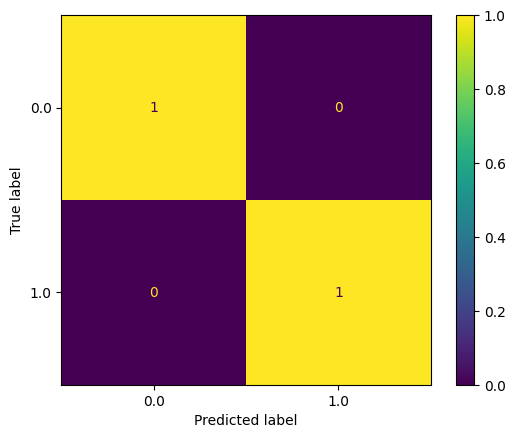

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Confusion matrix for full data without undersampling
ConfusionMatrixDisplay.from_estimator(ada_boost_classifier_c, x_train, y_train, normalize='true')

In [39]:

# getting the recall score for train data
from sklearn.metrics import recall_score, classification_report , accuracy_score

predictions_val = ada_boost_classifier_c.predict(x_val)

report_train= classification_report(y_val, predictions_val)
print(report_train)



              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       115
         1.0       0.94      0.94      0.94        49

    accuracy                           0.96       164
   macro avg       0.96      0.96      0.96       164
weighted avg       0.96      0.96      0.96       164



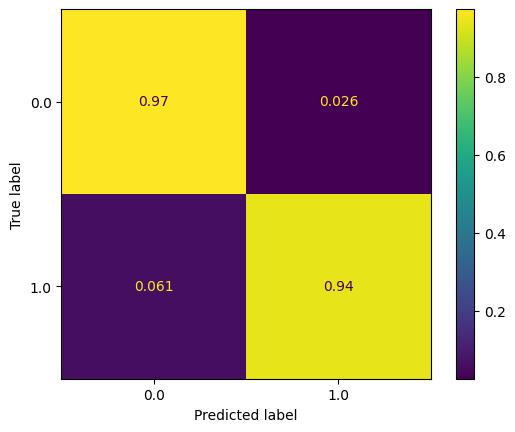

In [40]:


# Confusion matrix for full data without undersampling
ConfusionMatrixDisplay.from_estimator(ada_boost_classifier_c, x_val, y_val, normalize='true')

In [41]:
# Getting the ROC score for train


from sklearn.metrics import roc_auc_score

proba_predictions = ada_boost_classifier_c.predict_proba(x_train)

roc_auc = roc_auc_score(y_train, proba_predictions[:, 1])

roc_auc

1.0

In [42]:

from sklearn.metrics import roc_auc_score

proba_predictions = ada_boost_classifier_c.predict_proba(x_val)

roc_auc = roc_auc_score(y_val, proba_predictions[:, 1])

roc_auc

0.9904170363797693

In [43]:
# Preparing the features on test data


cat_features_test=test_cleaned.pop('conf')
num_features_test=test_cleaned




In [44]:
# Applying one hot encoding to test data


test_ohe= OneHotEncoder(sparse_output=False)

ohe_array_test=test_ohe.fit_transform(pd.DataFrame(cat_features_test,columns=['conf']))

In [45]:
#  Applying scaling to test data


test_scale= StandardScaler()

scale_array_test= test_scale.fit_transform(num_features_test)

In [46]:
# Turning OHE in test into dataframe

x_test_processed=pd.DataFrame(ohe_array_test, columns=test_ohe.get_feature_names_out())

In [47]:
# Adding scaled features in test into dataframe

num_columns_test=list(num_features_test.select_dtypes('number').columns)




x_test_processed[num_columns_test]=scale_array_test

In [48]:
columns_train = features_train.columns.tolist()
columns_x_test_processed = x_test_processed.columns.tolist()


# Columns present in train but not in test
columns_only_in_train = [col for col in columns_train if col not in columns_x_test_processed]


columns_only_in_train

['conf_GWC', 'conf_Ind', 'conf_Ivy', 'conf_P10', 'conf_ind']

In [49]:
# Inserting additional columns to test dataframe so it matches the train data

x_test_processed[columns_only_in_train]=0

# Reindex DataFrame test to match the column order of DataFrame train
x_test_processed = x_test_processed.reindex(columns=features_train.columns)


In [50]:
x_test_processed.to_csv('../data/processed/experiment_C_test_x.csv', index=False)

In [51]:


prediction_test= ada_boost_classifier_c.predict(x_test_processed)

proba_predictions_test = ada_boost_classifier_c.predict_proba(x_test_processed)


player_id=test_dataset['player_id']

# Converting series to dataframe
test_prediction = pd.DataFrame({'player_id': player_id})

# Adding the probability
test_prediction['drafted']=proba_predictions_test[:,1]



In [52]:
# !git add .
# !git commit -m "Finishing up experiment C, adaptivebooster"
# !git push

In [53]:
x_test_processed.to_csv('../data/processed/experiment_C_test_x.csv', index=False)

In [54]:
test_prediction.to_csv('../data/processed/experiment_C_prediction.csv', index=False)

In [55]:
# !git add .
# !git commit -m "Dumping models to the model folder"
# !git push